In [33]:
import torch
from matplotlib import pyplot as plt
import numpy as np

In [35]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        act = torch.nn.Softplus()
        x = act(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [36]:
# copied from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [37]:
# random (uniform) sample points in (0,1).
def random_domain_points(n):
    #x = torch.rand((n,1), requires_grad=True)
    xhigh = 0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # [0.5,1)
    xlow  = -0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # (0,0.5]
    x = torch.cat((xlow, xhigh),0)
    return x

In [38]:
#torch.manual_seed(123)

# input 1 (x), output 4 (A, alpha, phi, chi), 32 nodes per layer, 3 hidden layers
# (#input, #output,#neurons in each hidden layer, #of hidden layers)
model = FCN(1,4,64,4)#.to(device)

#optimizer = torch.optim.Adam(list(model.parameters())+[omega],lr=1e-4)
omega = 0.895042*torch.ones(1)#.to(device) 
phi0  = 0.05 * torch.ones(1)
#torch.nn.Parameter(0.895042*torch.ones(1))

In [39]:

dir = "./GPU_non_compact_r_fixed_omega_v3/model_neurons64_h_layers4_rmax1000/"

#load trained model
model.load_state_dict(torch.load(dir + "model.pth"))

# load total loss list
loss_list = np.load(dir + "total_loss.npz")["loss"]
# load individual losses
losses = np.load(dir + "losses.npz")["loss"]
# load learning rate list
lr_list = np.load(dir + "learning_rate.npz")["lr"]


/tmp/ipykernel_23285/2789989274.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(dir + "model.pth"))


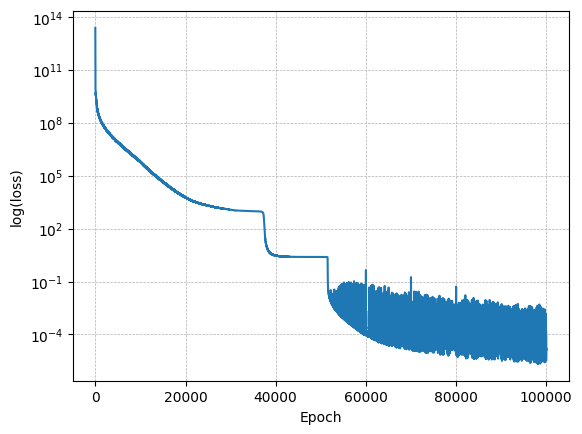

In [40]:
plt.semilogy(loss_list)
plt.xlabel("Epoch")
plt.ylabel("log(loss)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
#plt.savefig("./models/r_dom_fixed_omega_v3/loss.png", dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()  # Optional: Display the plot

Text(0, 0.5, 'log(losses[1])')

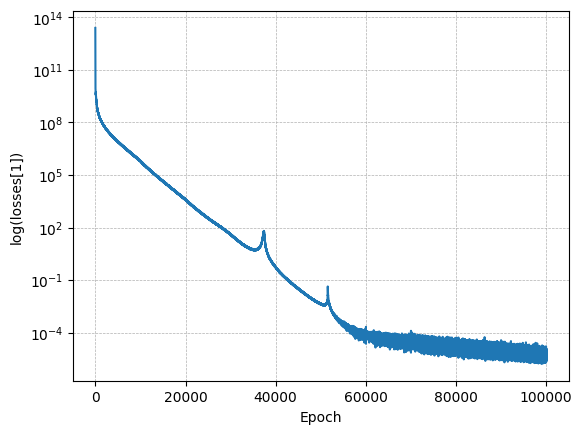

In [41]:
i = 1

ei = 0
ef = 100000

# Plot in the second subplot
plt.semilogy(losses[i, ei:ef])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel(f"log(losses[{i}])")

#plt.savefig(f"./models/r_dom_fixed_omega_v3/loss_{i}.png", dpi=300, bbox_inches='tight')  # Save with high resolution


In [42]:
R0 = torch.zeros(1, requires_grad=True)#.to(device)
nn_sol_r0 = model(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A, alpha, chi, phi = map(lambda i:  nn_sol_r0[[i]], range(4))
alphar = gradients(alpha, R0)

print("A_nn_r0 =",A.item())
print("A_r0    =",1)
print("")

print("alpha_nn_r0 =",alpha.item())
print("alpha_r0    >",0)
print("")

print("chi_nn_r0 =",chi.item())
print("chi_r0    =",0)
print("")

print("phi_nn_r0 =",phi.item())
print("phi0_r0   =",phi0.item())
print("")

print("alphar_nn_r0 =",alphar.item())
print("alphar_r0    =",0)

A_nn_r0 = 0.7350831627845764
A_r0    = 1

alpha_nn_r0 = 0.7187814712524414
alpha_r0    > 0

chi_nn_r0 = 0.16265001893043518
chi_r0    = 0

phi_nn_r0 = 0.3649452328681946
phi0_r0   = 0.05000000074505806

alphar_nn_r0 = -0.008731604553759098
alphar_r0    = 0


In [50]:
RMAX = 1000
rmax = RMAX*torch.ones(1, requires_grad=True)#.to(device)
nn_sol_rmax = model(rmax)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A, alpha, chi, phi = map(lambda i:  nn_sol_rmax[[i]], range(4))
alphar = gradients(alpha, rmax)

print("A_nn_rmax =",A.item())
print("A_rmax    =",1)
print("")

print("alpha_nn_rmax =",alpha.item())
print("alpha_rmax    =",1)
print("")

print("chi_nn_rmax =",chi.item())
print("chi_rmax    =",0)
print("")

print("phi_nn_rmax =",phi.item())
print("phi0_rmax   =",0)

A_nn_rmax = 0.5004127025604248
A_rmax    = 1

alpha_nn_rmax = 0.5921842455863953
alpha_rmax    = 1

chi_nn_rmax = 6.265076637268066
chi_rmax    = 0

phi_nn_rmax = 3.1836135387420654
phi0_rmax   = 0


In [ ]:
#plt.plot(omegas)

In [51]:
# the time domain; used to visualize the analytical solution
N = 1000
R = torch.linspace(0,RMAX,N)#.view(-1,10)
#print(t)

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
RR = torch.linspace(0,RMAX,N).view(-1,1)#.to(device)

nn_sol = model(RR).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A_nn, alpha_nn, chi_nn, phi_nn = map(lambda i:  nn_sol[:,[i]], range(4))


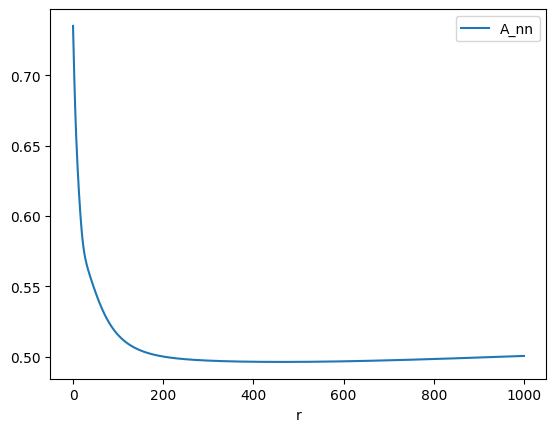

In [52]:
plt.plot(R, A_nn, label="A_nn")

plt.xlabel("r")
plt.legend()

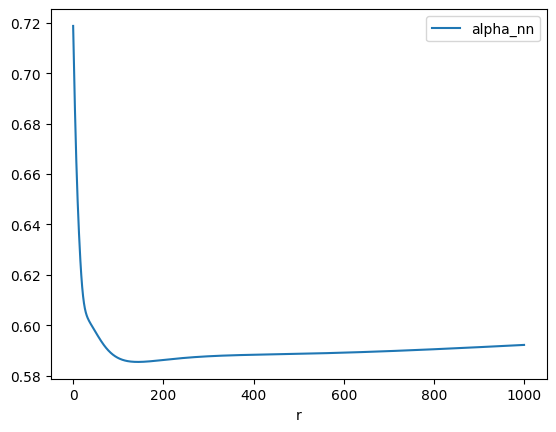

In [53]:
plt.plot(R, alpha_nn, label="alpha_nn")

plt.xlabel("r")
plt.legend()

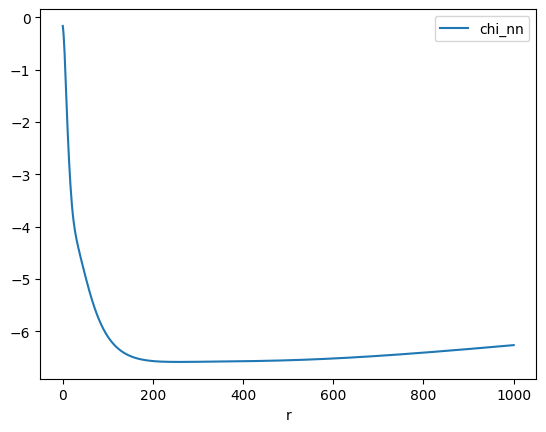

In [54]:
plt.plot(R, -chi_nn, label="chi_nn")

plt.xlabel("r")
plt.legend()

[0.36494526]


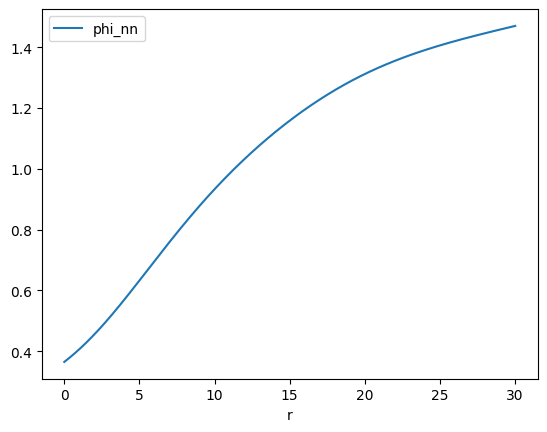

In [48]:
plt.plot(R, phi_nn, label="phi_nn")

print(phi_nn[0])

plt.xlabel("r")
#plt.ylim(0,0.2)
plt.legend()